# **Imports:**

---



In [1]:
# Set the path in Google Drive
model_iter = input('Enter model iteration: ')

Enter model iteration: pneumonia0


In [2]:
# basic imports
import sys
import os
import csv
import random

# Pytorch libaries
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import torchvision.models as models
from torch.utils.data import DataLoader, random_split, ConcatDataset, Subset
from torchvision.datasets import ImageFolder

# For loop
from timeit import default_timer as timer
from tqdm.auto import tqdm
from IPython.display import clear_output

# For visualizing and troubleshooting
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.metrics import confusion_matrix

# For saving a path and loading
from pathlib import Path
import requests
from google.colab import drive
drive.mount('/content/drive')
import zipfile

print("Imported successfully")

Mounted at /content/drive
Imported successfully


In [ ]:
print(f"Torch version: {torch.__version__}\n")
print(f"Torchvision version: {torchvision.__version__}\n")
print(f"CUDA version: {torch.version.cuda}\n")
print(f"cuDNN version: {torch.backends.cudnn.version()}\n")
print(f"Python version: {sys.version}")

In [4]:
def recall_fn(y_true, y_pred):
    """Calculates recall between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared.

    Returns:
        float: Recall value between y_true and y_pred.
    """
    # Convert probabilities/logits to binary predictions (if applicable)
    y_pred = y_pred.argmax(dim=1) if y_pred.ndim > 1 else y_pred
    y_true = y_true.type_as(y_pred)

    # Calculate True Positives (TP) and False Negatives (FN)
    TP = torch.logical_and(y_pred == 1, y_true == 1).sum().item()
    FN = torch.logical_and(y_pred == 0, y_true == 1).sum().item()

    # Calculate Recall
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0  # handle division by zero if there are no positives
    return recall * 100

In [5]:
def precision_fn(y_true, y_pred):
    """Calculates precision between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared.

    Returns:
        float: Precision value between y_true and y_pred.
    """
    # Convert probabilities/logits to binary predictions (if applicable)
    y_pred = y_pred.argmax(dim=1) if y_pred.ndim > 1 else y_pred
    y_true = y_true.type_as(y_pred)

    # Calculate True Positives (TP) and False Positives (FP)
    TP = torch.logical_and(y_pred == 1, y_true == 1).sum().item()
    FP = torch.logical_and(y_pred == 1, y_true == 0).sum().item()

    # Calculate Precision
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0  # handle division by zero if there are no positive predictions
    return precision * 100

In [6]:
def specificity_fn(y_true, y_pred):
    """
    Calculates specificity between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared.

    Returns:
        float: Specificity value between y_true and y_pred.
    """
    # Convert probabilities/logits to binary predictions (if applicable)
    y_pred = y_pred.argmax(dim=1) if y_pred.ndim > 1 else y_pred
    y_true = y_true.type_as(y_pred)

    # Calculate True Negatives (TN) and False Positives (FP)
    TN = torch.logical_and(y_pred == 0, y_true == 0).sum().item()
    FP = torch.logical_and(y_pred == 1, y_true == 0).sum().item()

    # Calculate Specificity
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0  # handle division by zero if there are no negatives
    return specificity * 100

# **Training loop setup:**

---



In [7]:
device = 'cuda' if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [8]:
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, download skipped")
else:
  print("helper_functions.py DNE, download initiated")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import accuracy_fn, print_train_time

if 'accuracy_fn' and 'print_train_time' in dir():
    print("Both functions are imported.")
else:
    print("Accuracy function is not imported.")

helper_functions.py DNE, download initiated
Both functions are imported.


In [9]:
def train_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              optimizer: torch.optim.Optimizer,
              accuracy_fn,
              device: torch.device = device,
               ):
  train_loss, train_acc, train_recall, train_prec, train_spec = 0, 0, 0, 0, 0

  # For training
  model.train()
  for batch, (image, label) in enumerate(data_loader):

    # Optimizer zero grad
    optimizer.zero_grad()

    # Forward pass
    image = image.to(device)
    label = label.to(device, dtype=torch.float)
    pred = model(image).squeeze()

    # Calculate the loss
    loss = loss_fn(pred, label)
    train_loss += loss

    # Calculate the accuracy
    train_acc += accuracy_fn(y_true = label,
                             y_pred = torch.round(torch.sigmoid(pred)))

     # Recall calculation
    train_recall += recall_fn(label,
                             torch.round(torch.sigmoid(pred)))

      # Precision calculation
    train_prec += precision_fn(label,
                              torch.round(torch.sigmoid(pred)))

      # Specificity calculation
    train_spec += specificity_fn(label,
                                torch.round(torch.sigmoid(pred)))

    # Backprop
    loss.backward()

    # Optimizer step
    optimizer.step()

  # For calculating average trainloss over every batch in each epoch
  scheduler.step()
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  train_recall /= len(data_loader)
  train_prec /= len(data_loader)
  train_spec /= len(data_loader)

  return train_loss, train_acc, train_recall, train_prec, train_spec

In [10]:
def test_step(model: torch.nn.Module,
                  data_loader: torch.utils.data.DataLoader,
                  loss_fn: torch.nn.Module,
                  optimizer: torch.optim.Optimizer,
                  accuracy_fn,
                  device: torch.device = device):

  test_loss, test_acc, test_recall, test_prec, test_spec = 0, 0, 0, 0, 0

  # For testing
  model.eval()

  with torch.inference_mode():
    for batch, (image, label) in enumerate(data_loader):
      # Forward pass
      image = image.to(device)
      label = label.to(device, dtype=torch.float)
      pred = model(image).squeeze()

      # Loss calculation
      loss = loss_fn(pred, label)
      test_loss += loss

      # Accuracy calculation
      test_acc += accuracy_fn(label,
                              torch.round(torch.sigmoid(pred)))

      # Recall calculation
      test_recall += recall_fn(label,
                               torch.round(torch.sigmoid(pred)))

      # Precision calculation
      test_prec += precision_fn(label,
                                torch.round(torch.sigmoid(pred)))

      # Specificity calculation
      test_spec += specificity_fn(label,
                                  torch.round(torch.sigmoid(pred)))

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    test_recall /= len(data_loader)
    test_prec /= len(data_loader)
    test_spec /= len(data_loader)

  return test_loss, test_acc, test_recall, test_prec, test_spec

# **Resnet18**

---



In [11]:
model = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model.fc.in_features
num_classes = 1
model.fc = nn.Linear(num_ftrs, num_classes)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 183MB/s]


# **Data Loading:**

---



In [12]:
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/pneum_binary.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

In [14]:
def load_dataset(dataset_path, transform=None):
    return ImageFolder(dataset_path, transform=transform)

# Define your transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

combined_dataset = load_dataset('/tmp/pneum_binary', transform=transform)

print(f"Class types: {combined_dataset.classes}")


# Split the subset into train and test sets
train_size = int(0.8 * len(combined_dataset))  # 80% for training
test_size = len(combined_dataset) - train_size  # 20% for testing
train_dataset, test_dataset = random_split(combined_dataset, [train_size, test_size])

# Create DataLoaders for train and test sets
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

Class types: ['normal', 'pneumonia']


# **Data Checks:**

---



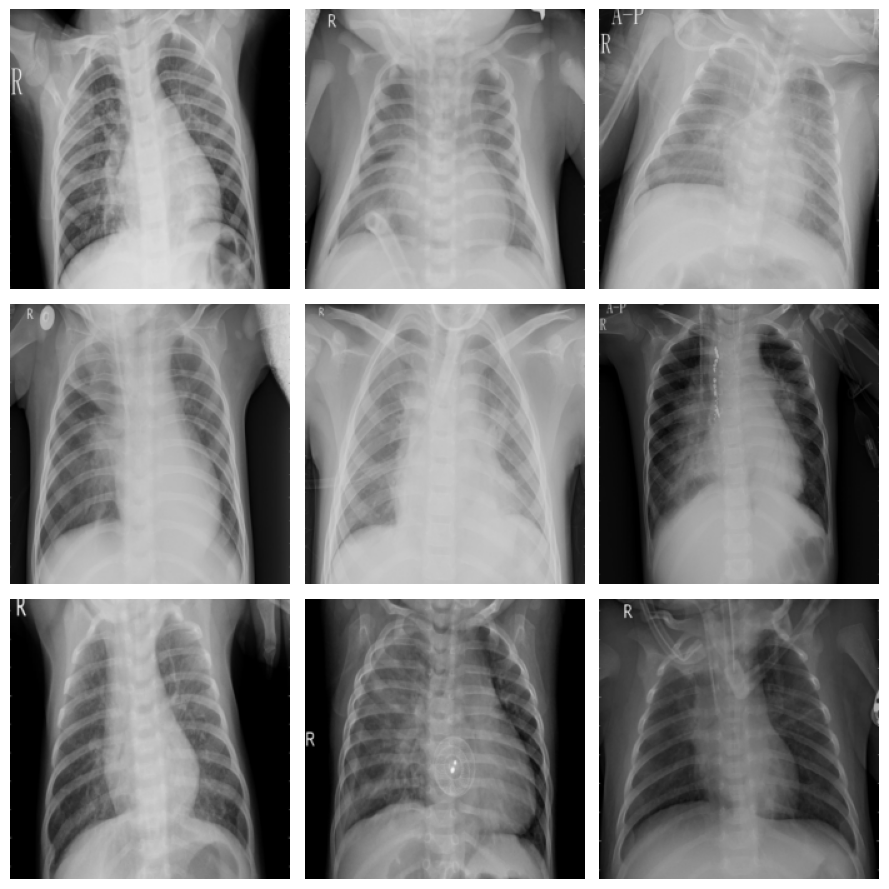

In [15]:
def get_random_images(data_loader, num_images=9):
    images = []
    labels = []  # Optional: Collect labels if you need them

    for image_batch, label_batch in data_loader:
        # Convert batch size to a list of indices, shuffle them
        indices = torch.randperm(len(image_batch))

        # Iterate over shuffled indices to select images randomly
        for idx in indices:
            images.append(image_batch[idx])
            labels.append(label_batch[idx])
            if len(images) == num_images:
                return images, labels  # Stop when you have enough images

    return images, labels  # In case less than num_images are collected

# Function to display images
def show_images(images, cols=3):
    rows = (len(images) + cols - 1) // cols
    plt.figure(figsize=(cols * 3, rows * 3))
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i + 1)
        # Assuming images are in tensor format and need to be converted for display
        plt.imshow(image.numpy().transpose(1, 2, 0))
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Get and display the images
random_images, random_labels = get_random_images(train_dataloader, 9)
show_images(random_images)

In [16]:
def count_labels(data_loader):
    label_count = Counter()

    for _, labels in data_loader:
        label_count.update(labels.tolist())

    return label_count

def calculate_proportions(label_count):
    total_samples = sum(label_count.values())
    proportions = {label: round(count / total_samples, 3) for label, count in label_count.items()}
    return proportions

train_label_count = count_labels(train_dataloader)
test_label_count = count_labels(test_dataloader)

train_proportions = calculate_proportions(train_label_count)
test_proportions = calculate_proportions(test_label_count)

print("Training set label counts:", train_label_count)
print("")
print("Training set label proportions:")
for label, prop in train_proportions.items():
    print(f"Label {label}: {prop}")

print("Testing set label counts:", test_label_count)
print("")
print("Testing set label proportions:")
for label, prop in test_proportions.items():
    print(f"Label {label}: {prop}")


Training set label counts: Counter({1: 3404, 0: 1280})

Training set label proportions:
Label 1: 0.727
Label 0: 0.273
Testing set label counts: Counter({1: 869, 0: 303})

Testing set label proportions:
Label 0: 0.259
Label 1: 0.741


# **Model Training:**

---



In [17]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
loss_fn = nn.BCEWithLogitsLoss()

In [18]:
epochCount = []

trainLosses = []
testLosses = []

trainAccuracies = []
testAccuracies = []

trainRecalls = []
testRecalls = []

trainPrecisions = []
testPrecisions = []

trainSpeceficities = []
testSpeceficities = []

epochs = 3
timeStart = timer()

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}")
  print("----------------------------------")
  train_loss, train_acc, train_recall, train_prec, train_spec = train_step(model = model,
                                                                          data_loader = train_dataloader,
                                                                          loss_fn = loss_fn,
                                                                          optimizer = optimizer,
                                                                          accuracy_fn = accuracy_fn,
                                                                          device = device)
  print(f"Train loss: {train_loss: 5f} | Train acc: {train_acc:.2f}")

  test_loss, test_acc, test_recall, test_prec, test_spec= test_step(model = model,
                                                                    data_loader = test_dataloader,
                                                                    loss_fn = loss_fn,
                                                                    optimizer = optimizer,
                                                                    accuracy_fn = accuracy_fn,
                                                                    device = device)
  print(f"Test loss: {test_loss: 5f} | Test acc: {test_acc:.2f}\n")

  epochCount.append(epoch)

  trainLosses.append(train_loss)
  testLosses.append(test_loss)

  trainAccuracies.append(train_acc)
  testAccuracies.append(test_acc)

  trainRecalls.append(train_recall)
  testRecalls.append(test_recall)

  trainPrecisions.append(train_prec)
  testPrecisions.append(test_prec)

  trainSpeceficities.append(train_spec)
  testSpeceficities.append(test_spec)


timeEnd = timer()
totalTrainTime = print_train_time(start = timeStart,
                                  end = timeEnd,
                                  device = str(next(model.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
----------------------------------
Train loss:  0.174658 | Train acc: 93.69
Test loss:  0.249428 | Test acc: 88.02

Epoch: 1
----------------------------------
Train loss:  0.087339 | Train acc: 96.91
Test loss:  0.098415 | Test acc: 96.74

Epoch: 2
----------------------------------
Train loss:  0.059612 | Train acc: 97.93
Test loss:  0.113172 | Test acc: 95.52


Train time on cuda:0: 256.443 seconds


In [19]:
epochCount1 = np.array(epochCount)
trainLosses1 = np.array([tensor.detach().cpu() for tensor in trainLosses])
testLosses1 = np.array([tensor.detach().cpu() for tensor in testLosses])
trainAccuracies1 = np.array(trainAccuracies)
testAccuracies1 = np.array(testAccuracies)

df = pd.DataFrame({"Epoch": epochCount1,
                   "Train Loss": trainLosses1,
                   "Test Loss": testLosses1,
                   "Train Accuracy": trainAccuracies1,
                   "Test Accuracy": testAccuracies1,
                   "Train Recall": trainRecalls,
                   "Test Recall": testRecalls,
                   "Train Precision": trainPrecisions,
                   "Test Precision": testPrecisions,
                   "Train Specificity": trainSpeceficities,
                   "Test Specificity": testSpeceficities})
df.head(3)

,Epoch,Train Loss,Test Loss,Train Accuracy,Test Accuracy,Train Recall,Test Recall,Train Precision,Test Precision,Train Specificity,Test Specificity
0,0,0.174658,0.249428,93.693311,88.023649,96.776819,99.650350,94.923591,86.279671,87.177795,54.636250
1,1,0.087339,0.098415,96.910431,96.739865,98.230292,98.603316,97.504339,97.004939,94.921014,92.015571
2,2,0.059612,0.113172,97.930839,95.523649,98.964550,99.086895,98.207451,95.170003,96.459720,84.947912


# **Model saving:**

---

In [20]:
drive_path = Path('/content/drive/My Drive/models' + '/' + model_iter)
drive_path.mkdir(parents=True, exist_ok=True)

# Create a model save path
modelName = model_iter + '.pth'
modelSavePath = drive_path / modelName

print(f"SAVING MODEL TO: {modelSavePath}")

# Saving model info to text file
def save_model_info(model, epochs, total_train_time, optimizer, loss_fn, file_path, transform):
    with open(file_path, 'w') as file:
        # Model architecture
        file.write('**Model Architecture:**\n\n')
        file.write(str(model))
        file.write('\n\n')

        # Transformations
        file.write('**Transformations:**\n\n')
        file.write(str(transforms))
        file.write('\n\n')

        # Optimizer details
        file.write('**Optimizer Details:**\n\n')
        file.write(str(optimizer))
        file.write('\n\n')

        # Loss function details
        file.write('**Loss Function:**\n\n')
        file.write(str(loss_fn))
        file.write('\n\n')

        # Number of epochs
        file.write('**Number of Epochs:**\n\n')
        file.write(f'{epochs}\n\n')

        # Total training time
        file.write('**Total Training Time:**\n\n')
        file.write(f'{total_train_time:.2f} seconds\n')

textName = model_iter + '.txt'
modelInfoSavePath = drive_path / textName
save_model_info(model, epochs, totalTrainTime, optimizer, loss_fn, modelInfoSavePath, transform)
print(f"Model information saved to {modelInfoSavePath}")

# Example model save (replace `model.state_dict()` with your actual model's state dict)
torch.save(obj=model.state_dict(), f=modelSavePath)

SAVING MODEL TO: /content/drive/My Drive/models/pneumonia0/pneumonia0.pth
Model information saved to /content/drive/My Drive/models/pneumonia0/pneumonia0.txt


**Loss Plotting:**

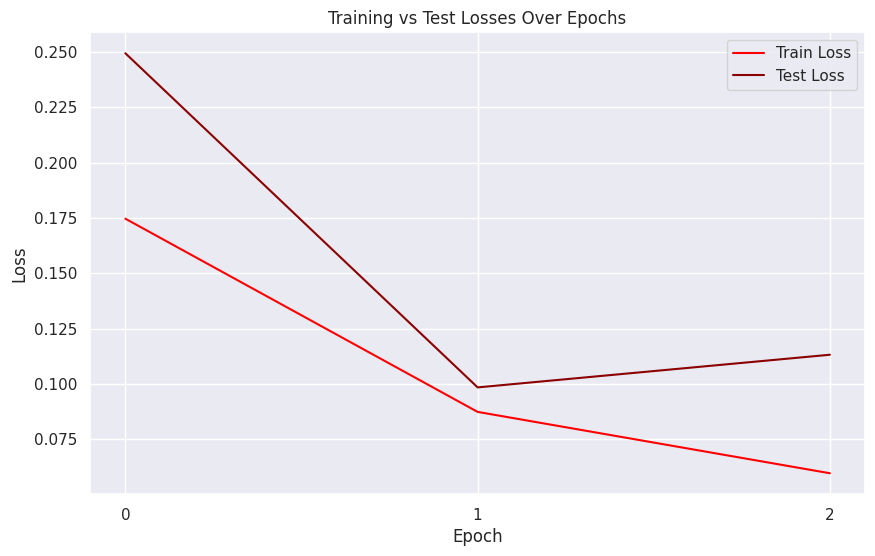

In [21]:
# Assuming 'df' is your DataFrame containing the epoch, training loss, and test loss data
sns.set()  # Sets the default seaborn style

plt.figure(figsize=(10, 6))
sns.lineplot(x='Epoch', y='Train Loss', data=df, label='Train Loss', color = 'red')
sns.lineplot(x='Epoch', y='Test Loss', data=df, label='Test Loss', color = 'darkred')

plt.title('Training vs Test Losses Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.xticks(ticks=range(0, epochs, 1))

# Saving the second graph
graph_save_path_2 = drive_path / 'loss_plot.png'
plt.savefig(graph_save_path_2)
plt.show()

**Accuracy Plotting:**

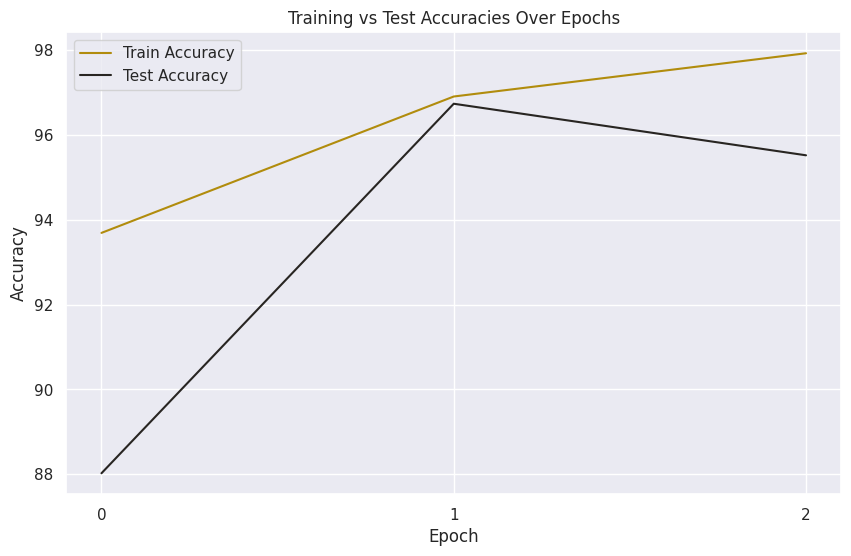

In [22]:
# Assuming 'df' is your DataFrame containing the epoch, training loss, and test loss data
sns.set()  # Sets the default seaborn style
palette = sns.dark_palette("xkcd:golden", n_colors=4, reverse=True)  # Two colors, one for each line

plt.figure(figsize=(10, 6))
sns.lineplot(x='Epoch', y='Train Accuracy', data=df, label='Train Accuracy', color = palette[1])
sns.lineplot(x='Epoch', y='Test Accuracy', data=df, label='Test Accuracy', color = palette[3])

plt.title('Training vs Test Accuracies Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(ticks=range(0, epochs, 1))

# Saving the second graph
graph_save_path_2 = drive_path / 'accuracy_plot.png'
plt.savefig(graph_save_path_2)
plt.show()

**Recall Plotting:**

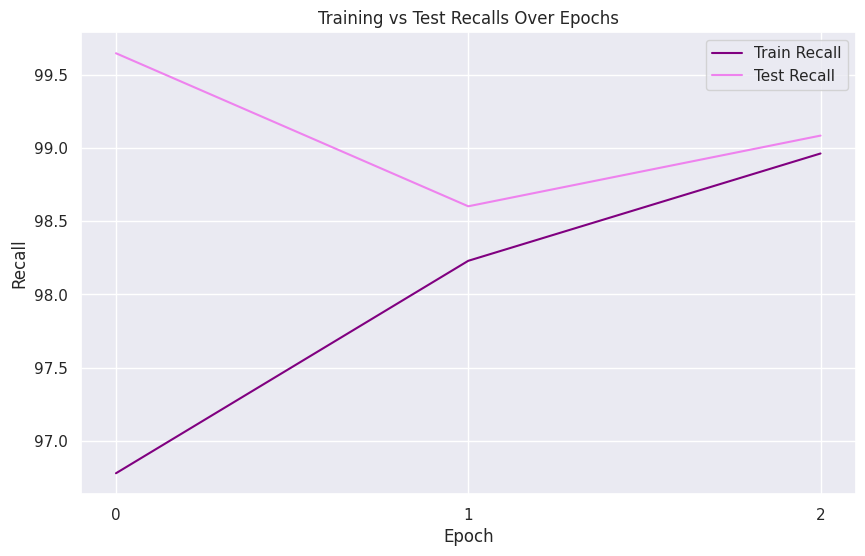

In [23]:
sns.set()
plt.figure(figsize=(10, 6))
sns.lineplot(x='Epoch', y='Train Recall', data=df, label='Train Recall', color='purple')
sns.lineplot(x='Epoch', y='Test Recall', data=df, label='Test Recall', color='violet')

plt.title('Training vs Test Recalls Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.xticks(ticks=range(0, epochs, 1))

graph_save_path_recall = drive_path / 'recall_plot.png'
plt.savefig(graph_save_path_recall)
plt.show()

**Precision Plotting:**

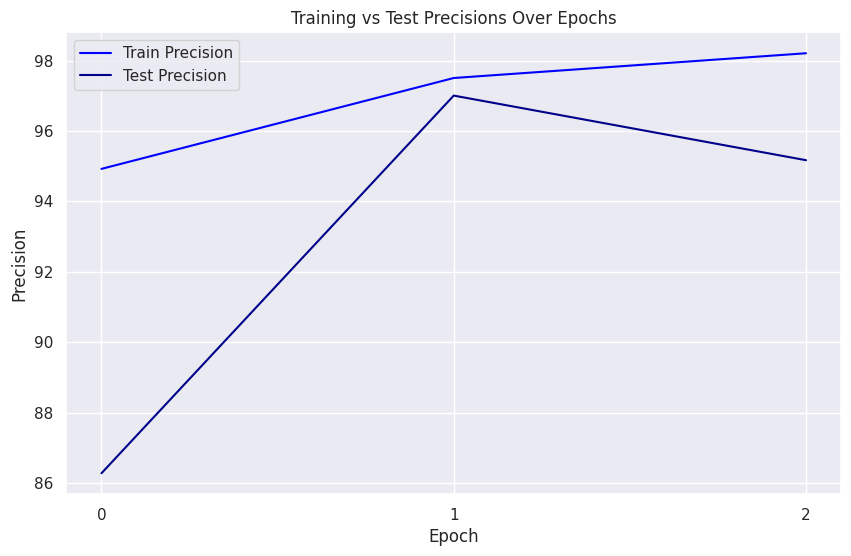

In [24]:
sns.set()
plt.figure(figsize=(10, 6))
sns.lineplot(x='Epoch', y='Train Precision', data=df, label='Train Precision', color='blue')
sns.lineplot(x='Epoch', y='Test Precision', data=df, label='Test Precision', color='darkblue')

plt.title('Training vs Test Precisions Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.xticks(ticks=range(0, epochs, 1))

graph_save_path_precision = drive_path / 'precision_plot.png'
plt.savefig(graph_save_path_precision)
plt.show()

**Speceficity Plotting:**

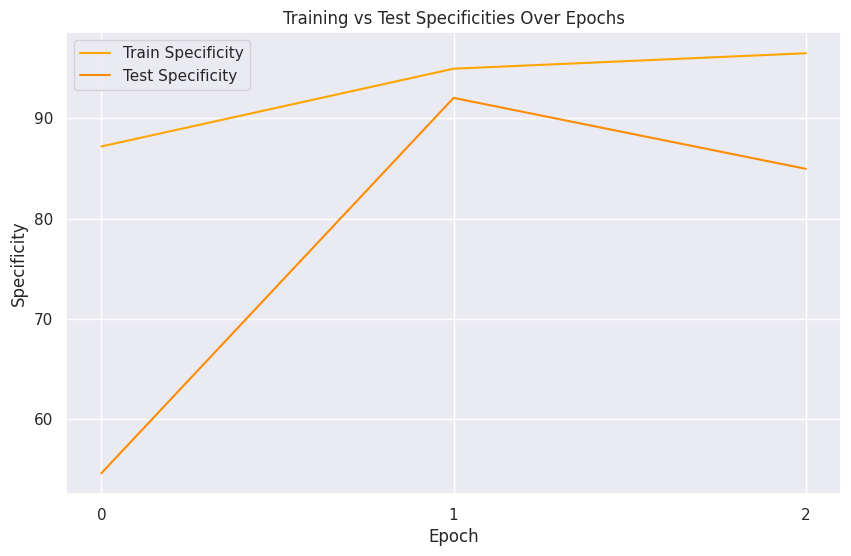

In [25]:
sns.set()
plt.figure(figsize=(10, 6))
sns.lineplot(x='Epoch', y='Train Specificity', data=df, label='Train Specificity', color='orange')
sns.lineplot(x='Epoch', y='Test Specificity', data=df, label='Test Specificity', color='darkorange')

plt.title('Training vs Test Specificities Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Specificity')
plt.legend()
plt.xticks(ticks=range(0, epochs, 1))

graph_save_path_specificity = drive_path / 'specificity_plot.png'
plt.savefig(graph_save_path_specificity)
plt.show()


**Confusion Matrix Plotting:**

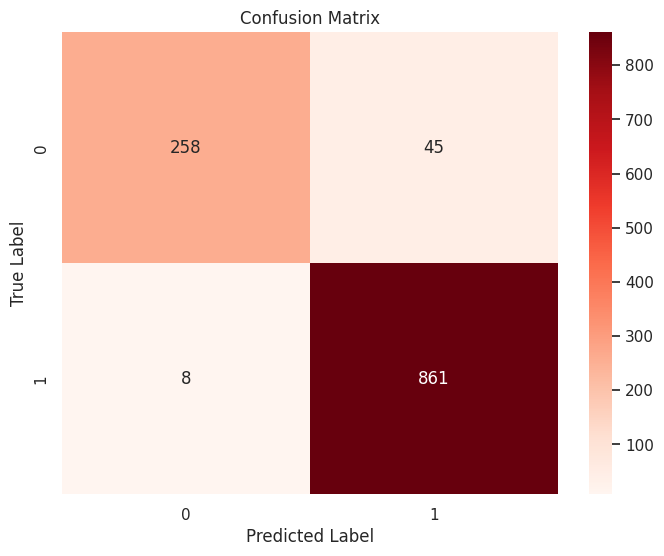

In [26]:
y_pred = []
y_true = []
y_pred_numpy = []
y_true_numpy = []

model.eval()
with torch.inference_mode():
    for batch, (image, label) in enumerate(test_dataloader):
      # Forward pass
      image = image.to(device)
      label = label.to(device, dtype=torch.float)
      pred = model(image).squeeze()
      pred = torch.round(torch.sigmoid(pred))

      # Loss calculation
      loss = loss_fn(pred, label)
      test_loss += loss

      # Accuracy calculation
      test_acc += accuracy_fn(y_true = label,
                              y_pred = torch.round(torch.sigmoid(pred)))
      y_pred.append(pred)
      y_true.append(label)

# Convert lists to NumPy arrays
for tensor in y_pred:
    # Move the tensor to CPU and convert to numpy
    numpy_array = tensor.to('cpu').numpy()
    y_pred_numpy.append(numpy_array)

for tensor in y_true:
    # Move the tensor to CPU and convert to numpy
    numpy_array = tensor.to('cpu').numpy()
    y_true_numpy.append(numpy_array)

# Convert lists to NumPy arrays
y_pred_numpy = np.hstack(y_pred_numpy)
y_true_numpy = np.hstack(y_true_numpy)

# Compute the confusion matrix
cm = confusion_matrix(y_true_numpy, y_pred_numpy)

# Plotting using matplotlib and seaborn
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds")
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

**Stat Sheet:**

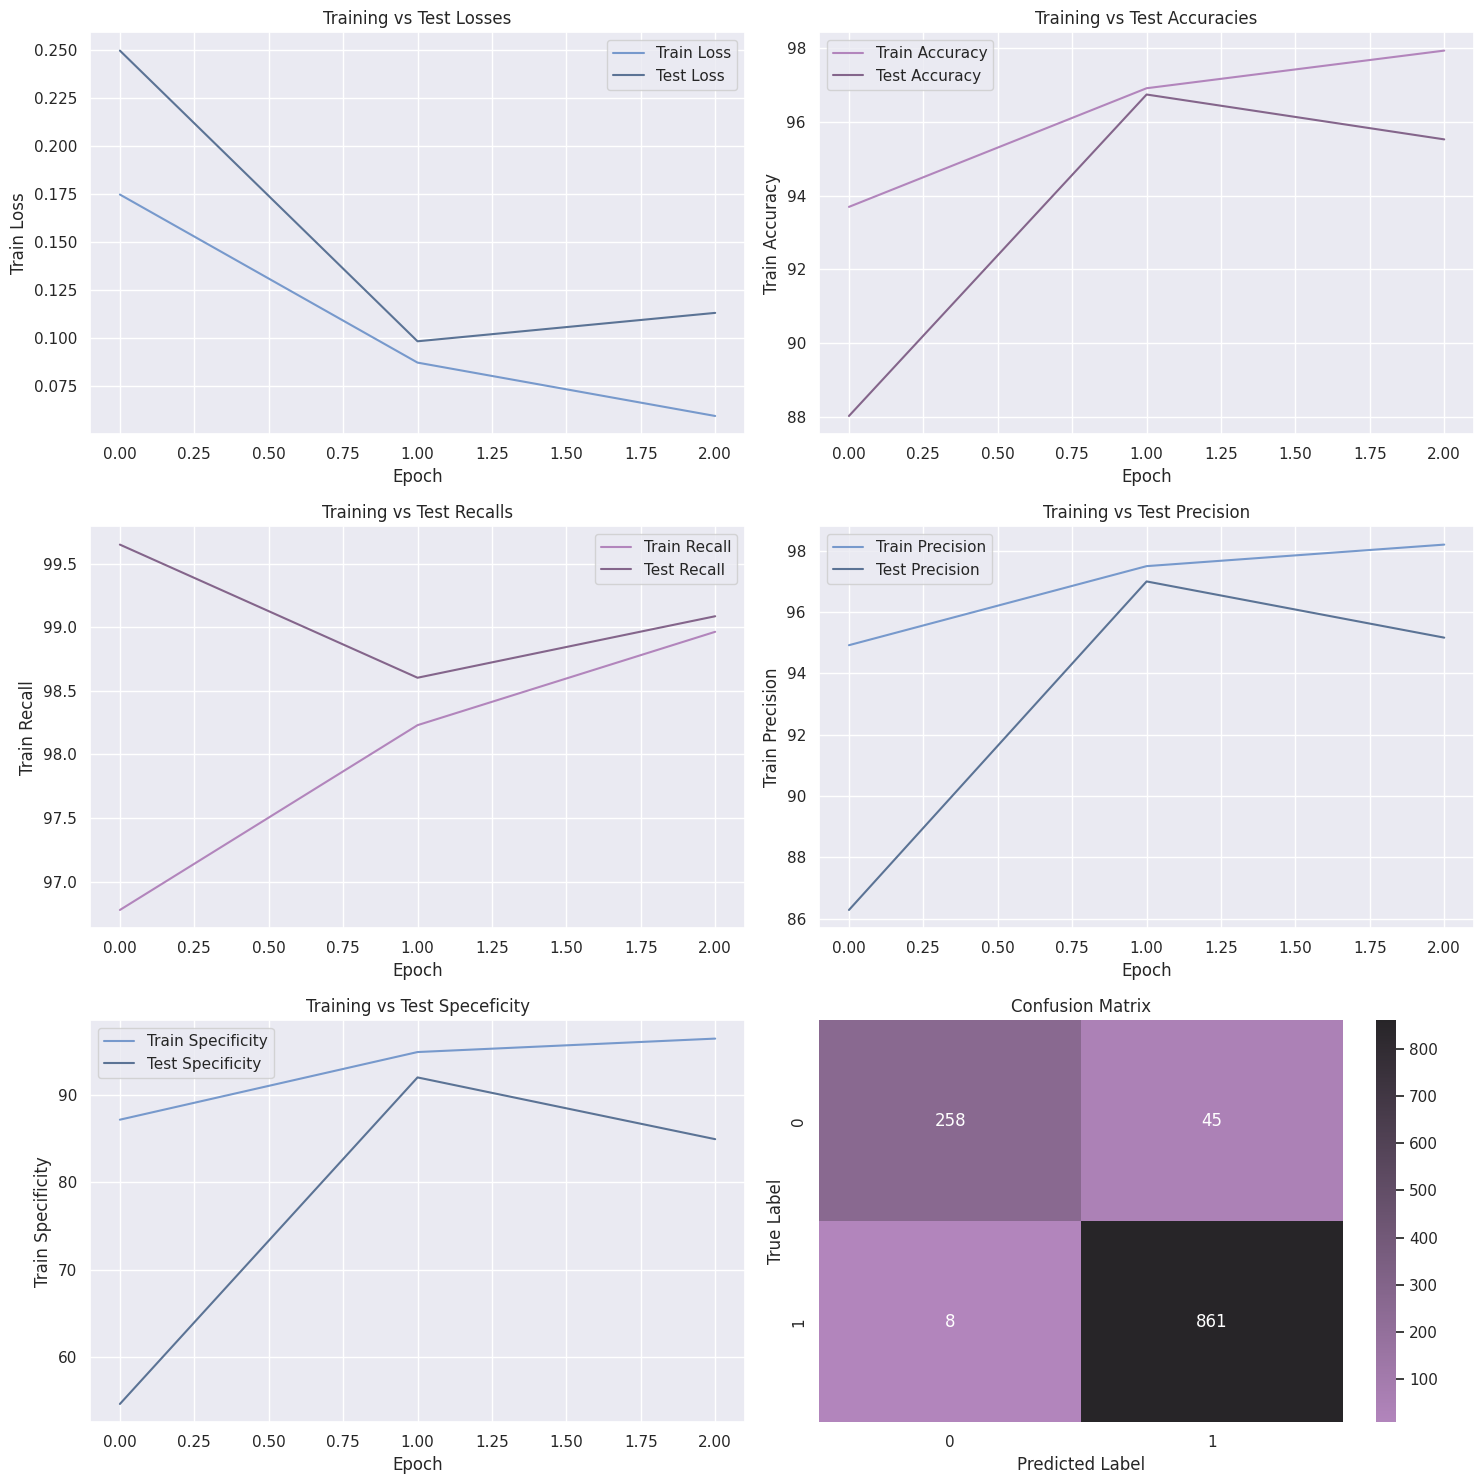

In [27]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np
import pandas as pd
from pathlib import Path


# Set a consistent style
sns.set()

# Create a figure with GridSpec
fig = plt.figure(figsize=(15, 15))  # Adjust the size as needed
gs = gridspec.GridSpec(3, 2, figure=fig, height_ratios=[1, 1, 1])

# Use the first four plots
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[1, 0])
ax4 = plt.subplot(gs[1, 1])
ax5 = plt.subplot(gs[2, 0])
ax6 = plt.subplot(gs[2, 1])

# Plot each metric

palette = sns.dark_palette("#79C", n_colors=4, reverse=True)
sns.lineplot(x='Epoch', y='Train Loss', data=df, label='Train Loss', color = palette[0], ax= ax1)
sns.lineplot(x='Epoch', y='Test Loss', data=df, label='Test Loss', color = palette[1], ax = ax1)
ax1.set_title('Training vs Test Losses')
ax1.legend()

palette = sns.dark_palette("#b285bc", n_colors=4, reverse=True)

sns.lineplot(x='Epoch', y='Train Accuracy', data=df, label='Train Accuracy', color = palette[0], ax = ax2)
sns.lineplot(x='Epoch', y='Test Accuracy', data=df, label='Test Accuracy', color = palette[1], ax = ax2)
ax2.set_title('Training vs Test Accuracies')
ax2.legend()


palette = sns.dark_palette("#b285bc", n_colors=4, reverse=True)
sns.lineplot(x='Epoch', y='Train Recall', data=df, label='Train Recall', color= palette[0], ax = ax3)
sns.lineplot(x='Epoch', y='Test Recall', data=df, label='Test Recall', color= palette[1], ax = ax3)
ax3.set_title('Training vs Test Recalls')
ax3.legend()

palette = sns.dark_palette("#79C", n_colors=4, reverse=True)
sns.lineplot(x='Epoch', y='Train Precision', data=df, label='Train Precision', color= palette[0],ax = ax4)
sns.lineplot(x='Epoch', y='Test Precision', data=df, label='Test Precision', color= palette[1], ax = ax4)
ax4.set_title('Training vs Test Precision')
ax4.legend()

palette = sns.dark_palette("#79C", n_colors=4, reverse=True)
sns.lineplot(x='Epoch', y='Train Specificity', data=df, label='Train Specificity', color= palette[0], ax = ax5)
sns.lineplot(x='Epoch', y='Test Specificity', data=df, label='Test Specificity', color= palette[1], ax = ax5)
ax5.set_title('Training vs Test Speceficity')
ax5.legend()

y_pred = []
y_true = []
y_pred_numpy = []
y_true_numpy = []

model.eval()
with torch.inference_mode():
    for batch, (image, label) in enumerate(test_dataloader):
      # Forward pass
      image = image.to(device)
      label = label.to(device, dtype=torch.float)
      pred = model(image).squeeze()
      pred = torch.round(torch.sigmoid(pred))

      # Loss calculation
      loss = loss_fn(pred, label)
      test_loss += loss

      # Accuracy calculation
      test_acc += accuracy_fn(y_true = label,
                              y_pred = torch.round(torch.sigmoid(pred)))
      y_pred.append(pred)
      y_true.append(label)

# Convert lists to NumPy arrays
for tensor in y_pred:
    # Move the tensor to CPU and convert to numpy
    numpy_array = tensor.to('cpu').numpy()
    y_pred_numpy.append(numpy_array)

for tensor in y_true:
    # Move the tensor to CPU and convert to numpy
    numpy_array = tensor.to('cpu').numpy()
    y_true_numpy.append(numpy_array)

# Convert lists to NumPy arrays
y_pred_numpy = np.hstack(y_pred_numpy)
y_true_numpy = np.hstack(y_true_numpy)

# Compute the confusion matrix
palette = sns.dark_palette("#b285bc", n_colors=4, reverse=True, as_cmap=True)
cm = confusion_matrix(y_true_numpy, y_pred_numpy)
sns.heatmap(cm, annot=True, fmt="d", cmap=palette)
ax6.set_title('Confusion Matrix')
ax6.set_ylabel('True Label')
ax6.set_xlabel('Predicted Label')

# Adjust layout
plt.tight_layout()

# Save the entire figure
graph_save_path = drive_path / 'metrics_comparison.png'
plt.savefig(graph_save_path)

# Show the plot
plt.show()
